# Initialization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#In case, you wish to run code and catboost is not installed then run this cell
!pip install catboost

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import accuracy_score, confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

In [4]:
def plot_cm(y_true, y_pred, fname, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    ax.set_title(fname)
    fig.savefig('/content/drive/MyDrive/CSE578DVGroupProject/'+fname+'.png')

In [5]:
def modelComparison(data, label, dataset, encoding = 0, scaling = 0, test = 0.2):
  print("With", dataset)
  #Data pre-processing
  cat_cols = [x for x in data.columns.tolist() if data[x].dtype == 'O']
  bool_dict = {}
  cat_dict = {}
  for col in cat_cols:
    temp = list(data[col].unique())
    if (len(temp) == 2):
      bool_dict[col] = temp
    else:
      cat_dict[col] = temp
  print("Boolean-category columns:", bool_dict)
  print("Multi-category columns:", cat_dict)
  #Boolean-Category Columns
  for col in list(bool_dict.keys()):
    for idx, val in enumerate(bool_dict[col]):
      data[col].replace(to_replace = val, value = idx, inplace = True)
  #Multi-Category Columns
  #One-hot encoding
  if (encoding == 0):
    for col in list(cat_dict.keys()):
      data[col] = data[col].apply(lambda x: col+'_'+ x)
      temp = list(data[col].unique())
      for t in temp:
        data[t] = 0
        data.loc[list(data[data[col] == t].index), t] = 1
      data = data.drop(columns = [col])
  #Label encoding
  elif (encoding == 1):
    for col in list(cat_dict.keys()):
      for idx, val in enumerate(cat_dict[col]):
        data[col].replace(to_replace = val, value = idx, inplace = True)
  else:
    print("Input 0 or 1 for encoding")
    return

  #Data Scaling
  #MinMax Scaling
  if (scaling == 0):
    scaler = MinMaxScaler()
    scaledData = scaler.fit_transform(data)
    scaledData = pd.DataFrame(scaledData, columns=data.columns.tolist())
    print("MinMax Scaled Data Shape:", scaledData.shape)
  #Standard Scaling
  elif (scaling == 1):
    scaler = MinMaxScaler()
    scaledData = scaler.fit_transform(data)
    scaledData = pd.DataFrame(scaledData, columns=data.columns.tolist())
    print("Standard Scaled Data Shape:", scaledData.shape)
  #Unscaled
  elif (scaling == 2):
    scaledData = data.copy()
    print("Un-Scaled Data Shape:", scaledData.shape)
  else:
    print("Input 0, 1 or 2 for scaling")
    return

  #Creating Train, Validation and Test splits
  X_temp, X_test, y_temp, y_test = train_test_split(scaledData, label, test_size=test, random_state=19)
  X_train, X_cross, y_train, y_cross = train_test_split(X_temp, y_temp, test_size=test, random_state=19)
  del X_temp, y_temp
  print("Train Data:", X_train.shape, len(y_train))
  print("Validation Data:", X_cross.shape, len(y_cross))
  print("Test Data:", X_test.shape, len(y_test))
  #Initializing cross-validation function
  cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
  #12 Models Comparison with various hyper-parameter tuning
  best_models_list, best_train_accuracy, best_test_accuracy, refit_time, misclass = [], [], [], [], []
  
  #Logistic Regression
  clf = LogisticRegression()
  parameters = {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 'max_iter': [1000, 2500, 5000]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, verbose = 1, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best Logistic Regression Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  best_refit = grid.refit_time_
  refit_time.append(best_refit)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  plot_cm(y_cross, y_pred, dataset+'_LogReg')
  
  #Stochastic Gradient Descent Classifier
  clf = SGDClassifier()
  parameters = {'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], 'eta0': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, verbose = 1, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best Stochastic Gradient Decsent Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  best_refit = grid.refit_time_
  refit_time.append(best_refit)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  plot_cm(y_cross, y_pred, dataset+'_SGD')
  
  #Decision Tree Classifier
  clf = DecisionTreeClassifier()
  parameters = {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random']}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, verbose = 1, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best Decision Tree Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  best_refit = grid.refit_time_
  refit_time.append(best_refit)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  plot_cm(y_cross, y_pred, dataset+'_Tree')
  
  #Random Forest Classifier
  clf = RandomForestClassifier()
  parameters = {'criterion': ['gini', 'entropy'], 'n_estimators': [25, 50, 100, 200, 500]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, verbose = 1, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best Random Forest Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  best_refit = grid.refit_time_
  refit_time.append(best_refit)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  plot_cm(y_cross, y_pred, dataset+'_RF')
  
  #AdaBoost Classifier
  clf = AdaBoostClassifier()
  parameters = {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, verbose = 1, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best AdaBoost Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  best_refit = grid.refit_time_
  refit_time.append(best_refit)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  plot_cm(y_cross, y_pred, dataset+'_Ada')
  
  #k-Nearest Neighbor Classifier
  clf = KNeighborsClassifier()
  parameters = {'n_neighbors': [1, 5, 10, 20, 50], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, verbose = 1, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best k-Nearest Neighbor Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  best_refit = grid.refit_time_
  refit_time.append(best_refit)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  plot_cm(y_cross, y_pred, dataset+'_kNN')
  
  #Linear Discriminant Analysis
  clf = LinearDiscriminantAnalysis()
  parameters = {'solver': ['svd', 'lsqr', 'eigen']}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, verbose = 1, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best Linear Discriminant Analysis Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  best_refit = grid.refit_time_
  refit_time.append(best_refit)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  plot_cm(y_cross, y_pred, dataset+'_LDA')
  
  #Quadratic Discriminant Analysis
  clf = QuadraticDiscriminantAnalysis()
  parameters = {'reg_param': [0, 0.001, 0.01, 0.1]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, verbose = 1, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best Quadratic Discriminant Analysis Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  best_refit = grid.refit_time_
  refit_time.append(best_refit)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  plot_cm(y_cross, y_pred, dataset+'_QDA')
  
  #Gaussian Naive-Bayes Classifier
  clf = GaussianNB()
  parameters = {}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, verbose = 1, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best Gaussian Naive-Bayes Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  best_refit = grid.refit_time_
  refit_time.append(best_refit)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  plot_cm(y_cross, y_pred, dataset+'_NB')
  
  #Support Vector Machine
  clf = SVC() 
  parameters = {'C': [1, 10, 100], 'kernel': ['linear', 'rbf']}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, verbose = 1, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best Support Vector Machine Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  best_refit = grid.refit_time_
  refit_time.append(best_refit)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  plot_cm(y_cross, y_pred, dataset+'_SVM')
  
  #Artificial Neural Network Classifier
  clf = MLPClassifier()
  parameters = {'hidden_layer_sizes': [(5, 2), (4, 4, 2), (20, 2)], 'activation': ['relu'], 
                'solver': ['sgd', 'adam'], 'alpha': [0.0001, 0.01, 0.1, 1]}
  grid = GridSearchCV(clf, param_grid=parameters, cv=cv, verbose = 1, n_jobs = -1)
  grid.fit(X_train, y_train)
  print("Best Artificial Neural Network Classifier Model:", grid.best_estimator_)
  best_estimator = grid.best_estimator_
  best_models_list.append(best_estimator)
  best_refit = grid.refit_time_
  refit_time.append(best_refit)
  #Fetching predictions on test set for best model
  y_pred = best_estimator.predict(X_cross)
  #Evaluation of best model performance
  best_acc = accuracy_score(y_cross, y_pred)*100
  best_train_accuracy.append(grid.best_score_*100)
  best_test_accuracy.append(best_acc)
  count_misclassified = (y_cross != y_pred).sum()
  misclass.append(count_misclassified)
  plot_cm(y_cross, y_pred, dataset+'_ANN')
  
  #Model Performance Comparison 
  model_performance = pd.DataFrame(columns = ['Abbr', 'Model', 'Train Accuracy', 'Validation Accuracy', 'Refit Time', 'Misclassified Samples'])
  model_list = ['Logistic Regression', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'AdaBoot', 'k-Nearest Neighbors', 
                'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Naive-Bayes', 'Support Vector Machine', 'Neural Network']
  
  for i, txt in enumerate(model_list):
      val = {'Abbr': txt, 'Model': best_models_list[i], 'Train Accuracy': best_train_accuracy[i], 
            'Validation Accuracy': best_test_accuracy[i], 'Refit Time': refit_time[i],'Misclassified Samples': misclass[i]}
      model_performance = model_performance.append(val, ignore_index=True)
  model_performance = model_performance.sort_values(by=['Validation Accuracy', 'Train Accuracy', 'Refit Time'], ascending=[False, False, True])
  model_performance = model_performance.reset_index(drop = True)
  return X_test, y_test, model_performance

# Data Pre-Processing

In [6]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
           'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label']
data = pd.read_csv('/content/drive/MyDrive/CSE578DVGroupProject/adult-all.csv', header = None, na_values='?', names = columns)
data['label'].replace({'<=50K': 0, '>50K': 1}, inplace = True)
data = data.drop(columns = ['education-num'])
data.fillna('NA', inplace = True)
print(data.shape)
data.head()

(48842, 14)


,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [7]:
data['label'].value_counts()

0    37155
1    11687
Name: label, dtype: int64

# Model Training

## Label Encoding

With LE
Boolean-category columns: {'sex': ['Male', 'Female']}
Multi-category columns: {'workclass': ['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', 'NA', 'Self-emp-inc', 'Without-pay', 'Never-worked'], 'education': ['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college', 'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school', '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], 'marital-status': ['Never-married', 'Married-civ-spouse', 'Divorced', 'Married-spouse-absent', 'Separated', 'Married-AF-spouse', 'Widowed'], 'occupation': ['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners', 'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair', 'Transport-moving', 'Farming-fishing', 'Machine-op-inspct', 'Tech-support', 'NA', 'Protective-serv', 'Armed-Forces', 'Priv-house-serv'], 'relationship': ['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried', 'Other-relative'], 'race': ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.6s finished


Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   14.6s finished


Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.0s finished


Best Decision Tree Classifier Model: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished


Best Random Forest Classifier Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  6.3min finished


Best AdaBoost Classifier Model: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=500, random_state=None)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   58.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  8.0min finished


Best k-Nearest Neighbor Classifier Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.9s finished


Best Linear Discriminant Analysis Model: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished


Best Quadratic Discriminant Analysis Model: QuadraticDiscriminantAnalysis(priors=None, reg_param=0.001,
                              store_covariance=False, tol=0.0001)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


Best Gaussian Naive-Bayes Classifier Model: GaussianNB(priors=None, var_smoothing=1e-09)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 48.2min finished


Best Support Vector Machine Model: SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 15.6min finished


Best Artificial Neural Network Classifier Model: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


,Abbr,Model,Train Accuracy,Validation Accuracy,Refit Time,Misclassified Samples
0,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",86.874600,87.063340,12.546695,1011
1,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",85.611004,85.783749,19.198388,1111
2,Support Vector Machine,"SVC(C=100, break_ties=False, cache_size=200, c...",83.314139,83.608445,74.925117,1281
3,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",82.690339,82.981446,0.236617,1330
4,Neural Network,"MLPClassifier(activation='relu', alpha=0.0001,...",82.693538,82.303263,9.144346,1383
5,Decision Tree,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",81.397953,81.228407,0.243987,1467
6,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",80.073576,80.601408,0.249800,1516
7,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",80.543826,80.447857,0.024247,1528
8,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",80.057582,80.000000,0.322284,1563
9,Naive-Bayes,"GaussianNB(priors=None, var_smoothing=1e-09)",80.035189,79.961612,0.013417,1566


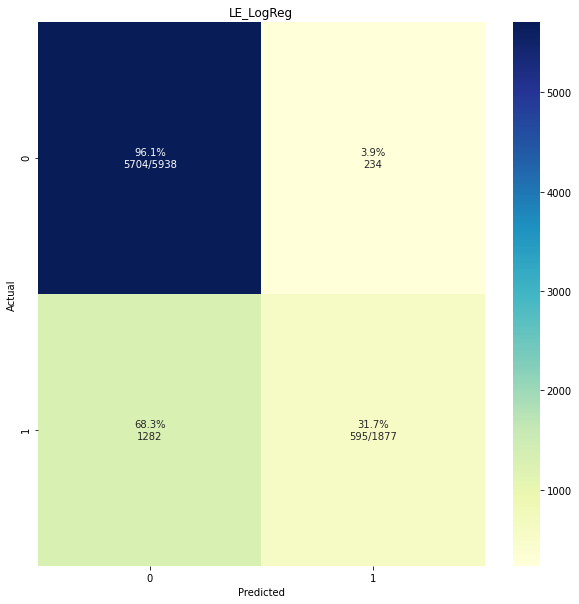

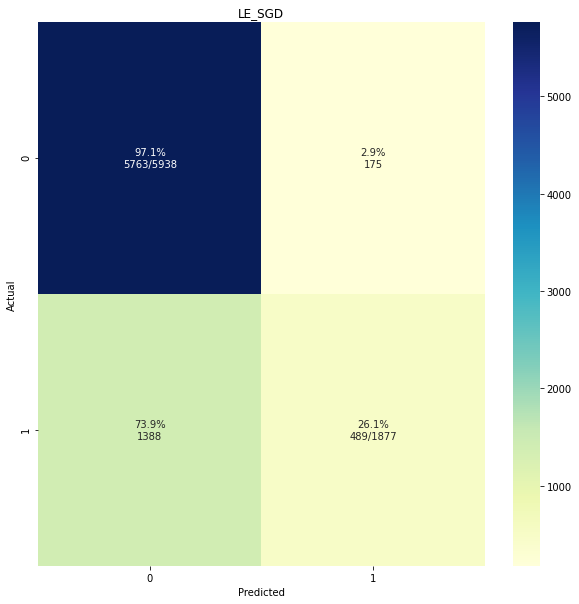

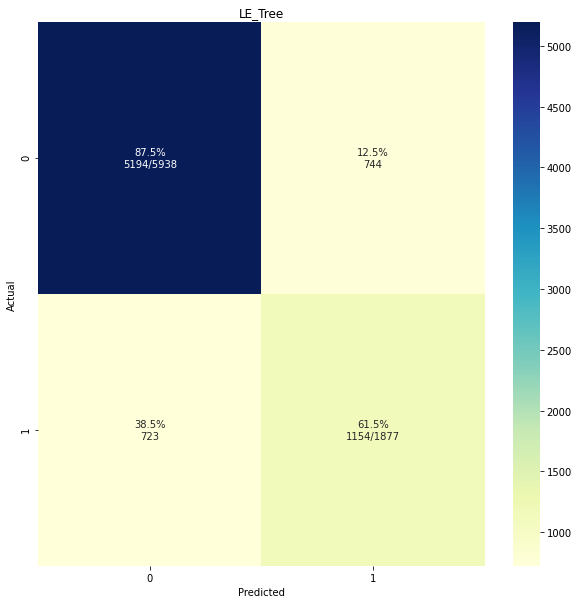

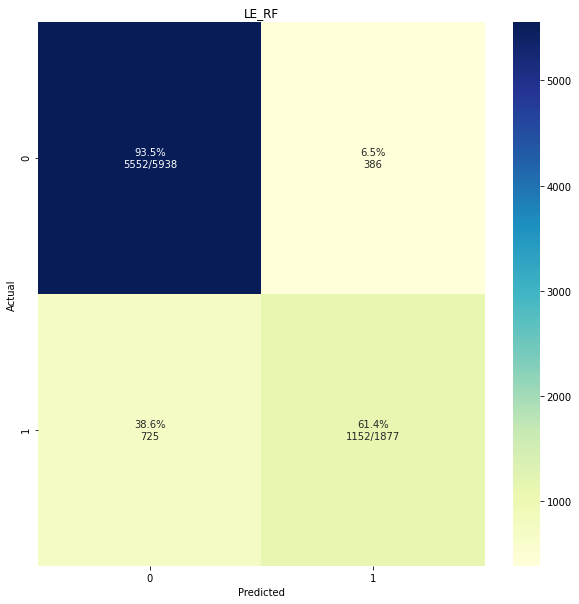

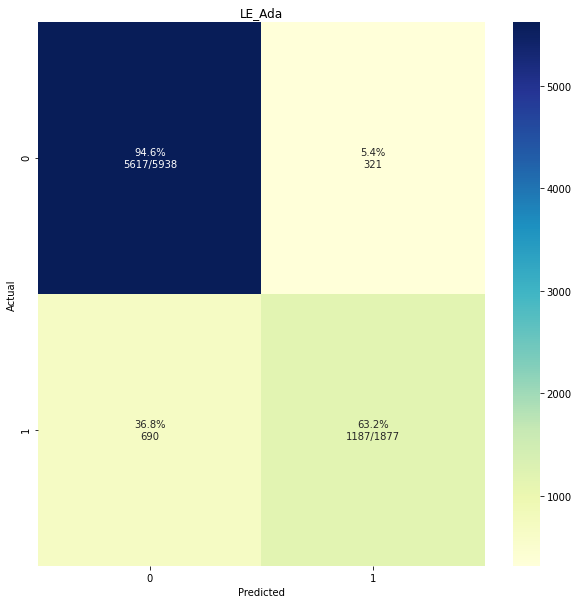

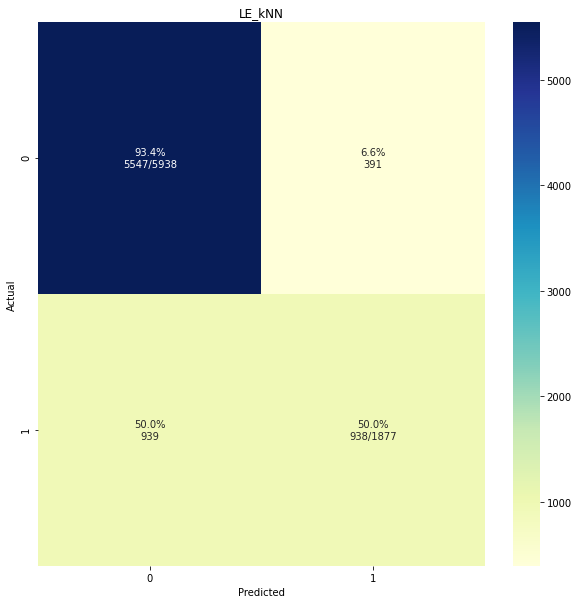

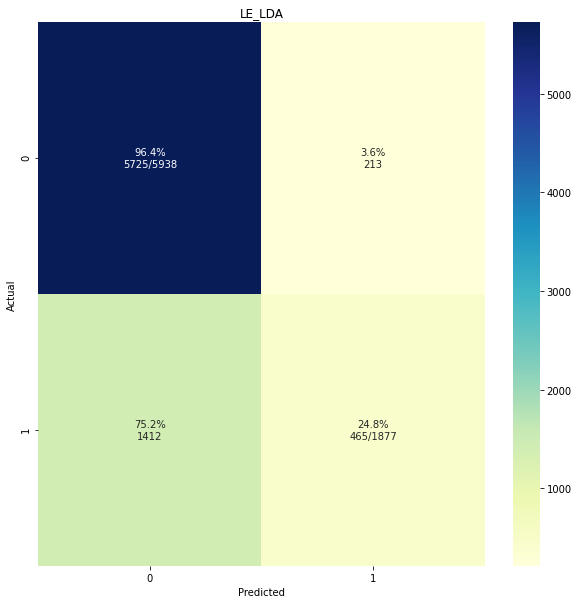

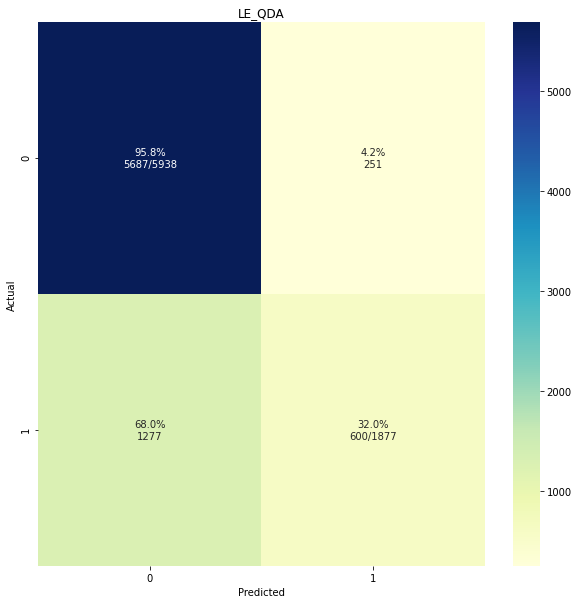

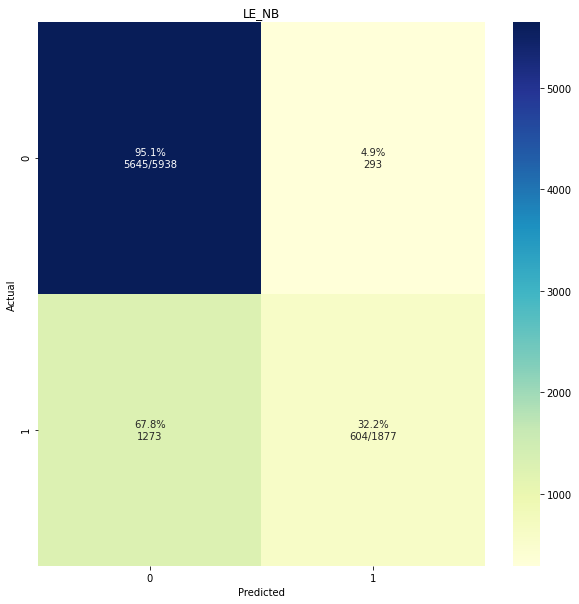

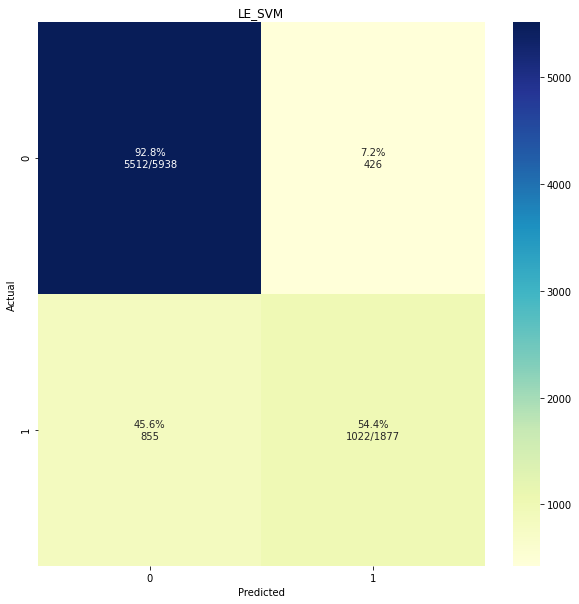

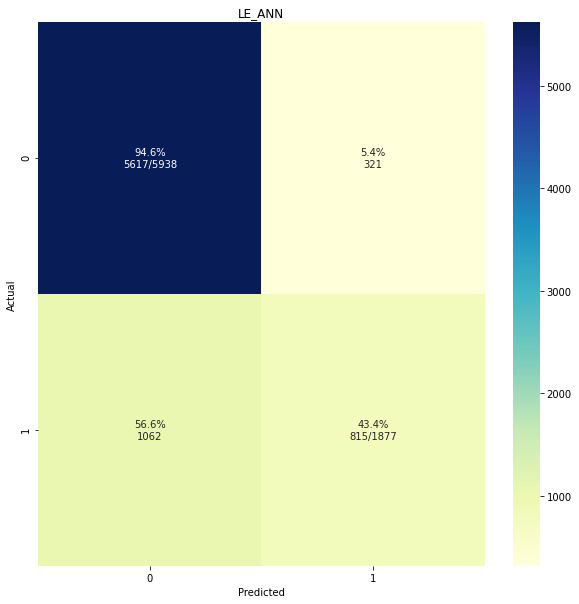

In [ ]:
X = data.drop(columns = ['label'])
y = data['label']
X_test, y_test, model_performance = modelComparison(X, y, 'LE', encoding = 1, scaling = 0, test = 0.2)
model_performance

In [ ]:
model_performance.to_csv('/content/drive/MyDrive/CSE578DVGroupProject/perf.csv', index = False)

## One Hot Encoding

With OHE
Boolean-category columns: {'sex': ['Male', 'Female']}
Multi-category columns: {'workclass': ['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov', 'Local-gov', 'NA', 'Self-emp-inc', 'Without-pay', 'Never-worked'], 'education': ['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college', 'Assoc-acdm', 'Assoc-voc', '7th-8th', 'Doctorate', 'Prof-school', '5th-6th', '10th', '1st-4th', 'Preschool', '12th'], 'marital-status': ['Never-married', 'Married-civ-spouse', 'Divorced', 'Married-spouse-absent', 'Separated', 'Married-AF-spouse', 'Widowed'], 'occupation': ['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners', 'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair', 'Transport-moving', 'Farming-fishing', 'Machine-op-inspct', 'Tech-support', 'NA', 'Protective-serv', 'Armed-Forces', 'Priv-house-serv'], 'relationship': ['Not-in-family', 'Husband', 'Wife', 'Own-child', 'Unmarried', 'Other-relative'], 'race': ['White', 'Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.4min finished


Best Logistic Regression Model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)
Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   56.4s finished


Best Stochastic Gradient Decsent Classifier Model: SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=100, fit_intercept=True,
              l1_ratio=0.15, learning_rate='adaptive', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.7s finished


Best Decision Tree Classifier Model: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.4min finished


Best Random Forest Classifier Model: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 13.8min finished


Best AdaBoost Classifier Model: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=500, random_state=None)
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 72.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 72.4min finished


Best k-Nearest Neighbor Classifier Model: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.6s finished


Best Linear Discriminant Analysis Model: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    9.2s finished


Best Quadratic Discriminant Analysis Model: QuadraticDiscriminantAnalysis(priors=None, reg_param=0.1,
                              store_covariance=False, tol=0.0001)
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Best Gaussian Naive-Bayes Classifier Model: GaussianNB(priors=None, var_smoothing=1e-09)
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 45.7min finished


Best Support Vector Machine Model: SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 22.9min finished


Best Artificial Neural Network Classifier Model: MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


,Abbr,Model,Train Accuracy,Validation Accuracy,Refit Time,Misclassified Samples
0,AdaBoot,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",86.705054,87.165707,26.476736,1003
1,Neural Network,"MLPClassifier(activation='relu', alpha=0.0001,...",85.214331,85.527831,14.311756,1131
2,Random Forest,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",85.319898,85.476647,35.342668,1135
3,Support Vector Machine,"SVC(C=100, break_ties=False, cache_size=200, c...",85.195138,85.335893,545.327144,1146
4,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",84.974408,85.182342,1.252151,1158
5,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",84.763276,85.041587,1.507967,1169
6,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",84.398592,84.529750,0.932439,1209
7,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",83.179782,83.928343,1.926785,1256
8,Decision Tree,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",81.583493,82.072937,0.567941,1401
9,Quadratic Discriminant Analysis,"QuadraticDiscriminantAnalysis(priors=None, reg...",75.287908,75.393474,0.516106,1923


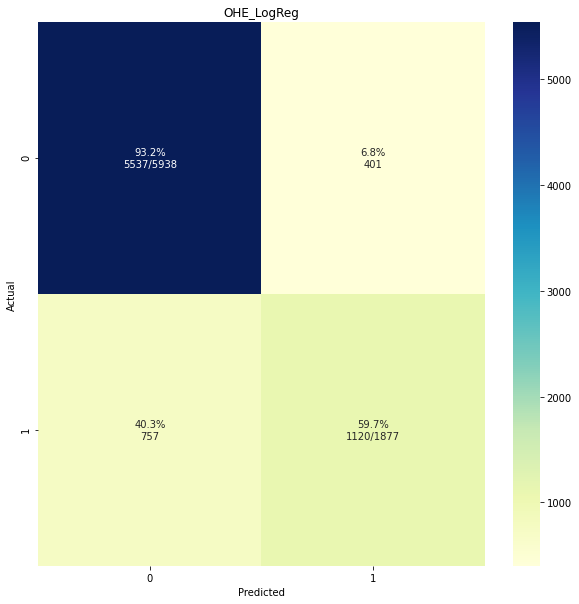

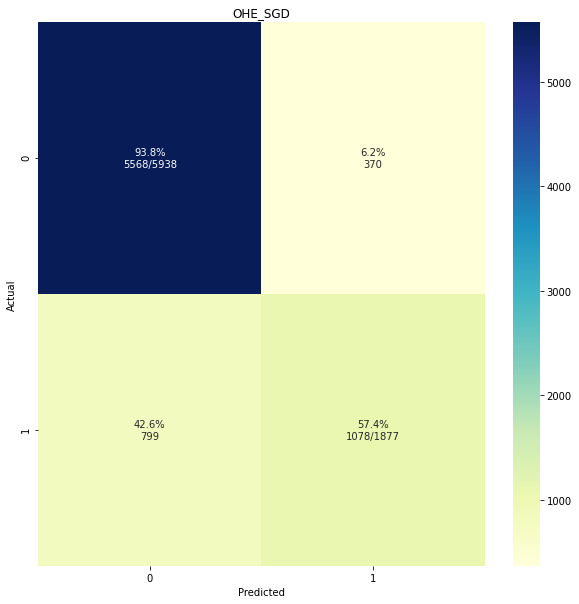

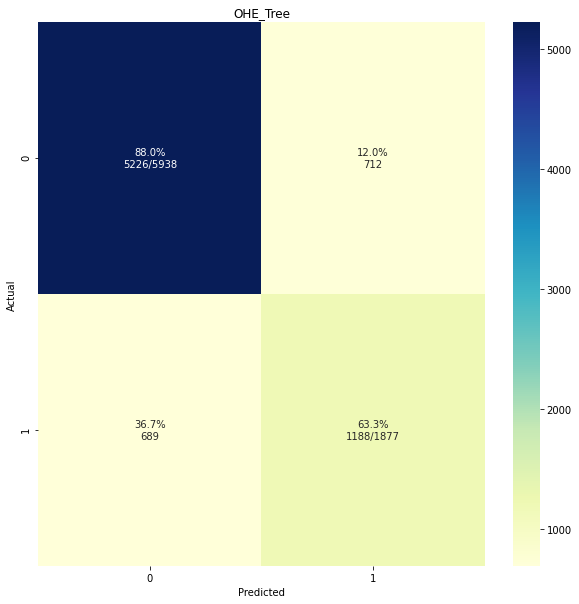

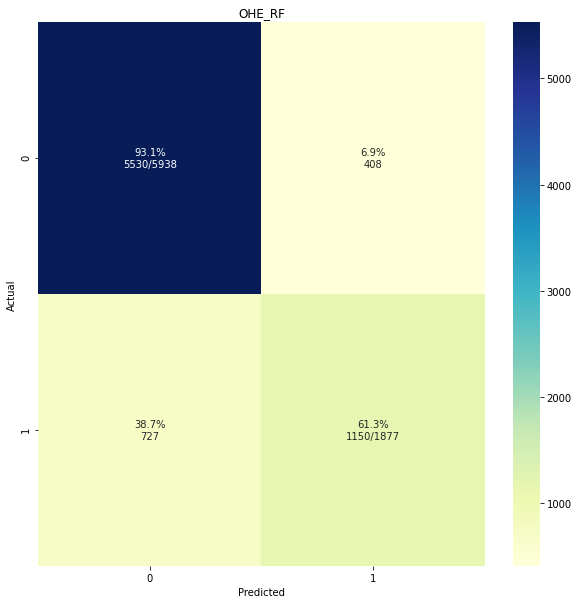

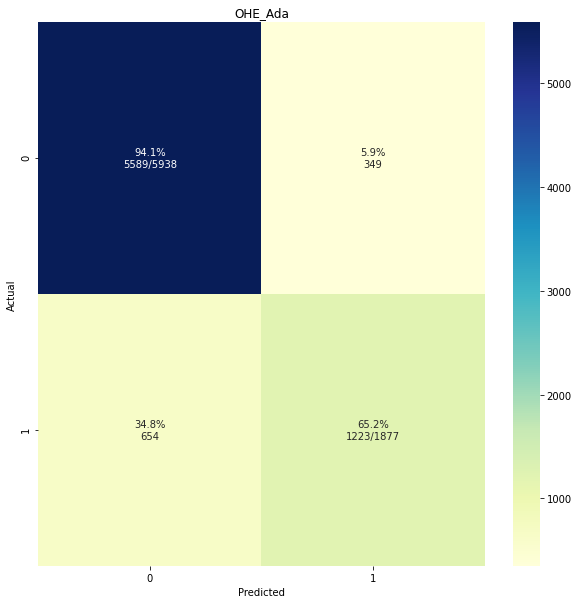

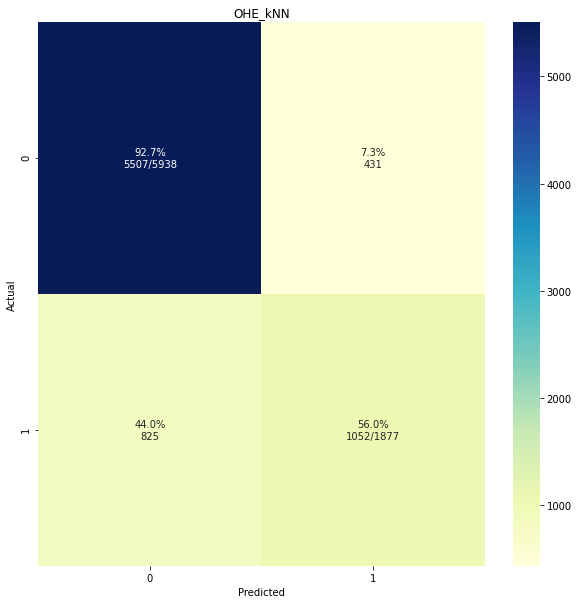

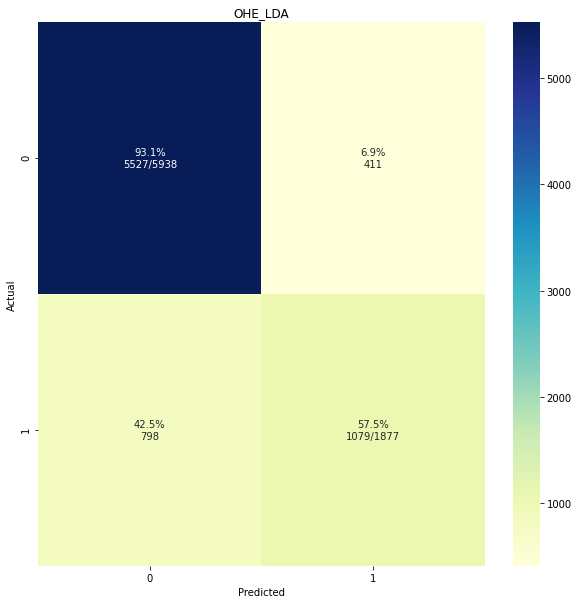

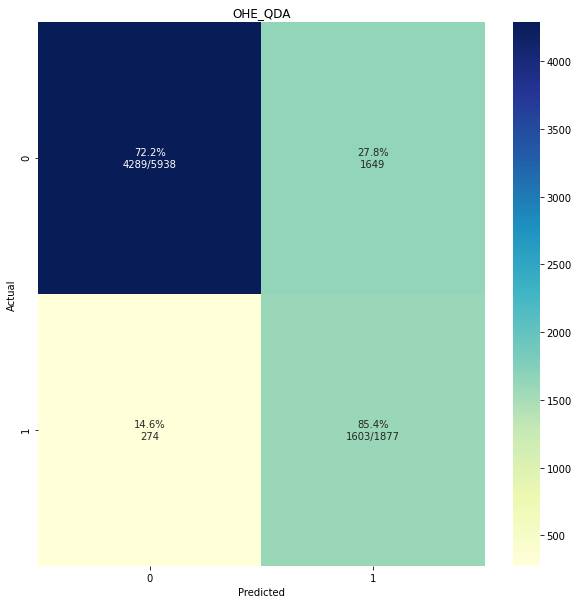

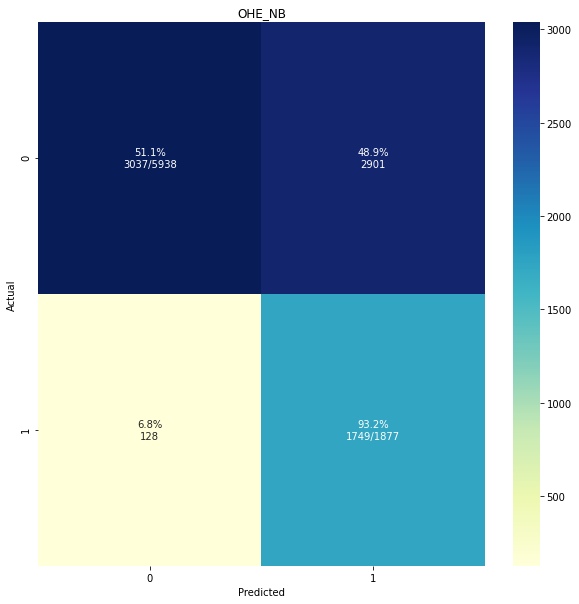

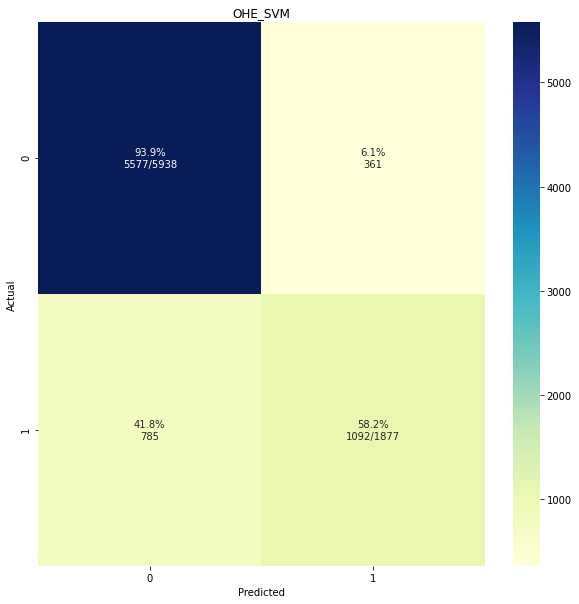

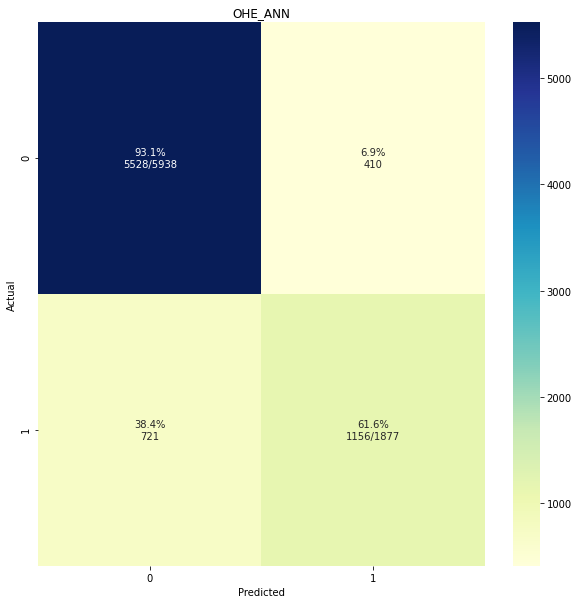

In [ ]:
X = data.drop(columns = ['label'])
y = data['label']
X_test2, y_test2, model_performance2 = modelComparison(X, y, 'OHE', encoding = 0, scaling = 0, test = 0.2)
model_performance2

In [ ]:
model_performance2.to_csv('/content/drive/MyDrive/CSE578DVGroupProject/perf2.csv', index = False)

## CatBoost

In [8]:
X = data.drop(columns = ['label'])
y = data['label']

catCols = [col for col in X.columns.tolist() if data[col].dtype == 'O']

#Creating Train, Validation and Test splits
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=19)
X_train, X_cross, y_train, y_cross = train_test_split(X_temp, y_temp, test_size=0.2, random_state=19)
del X_temp, y_temp
print("Train Data:", X_train.shape, len(X_train))
print("Validation Data:", X_cross.shape, len(y_cross))
print("Test Data:", X_test.shape, len(y_test))

model = CatBoostClassifier(one_hot_max_size = 100, learning_rate = 0.03, cat_features=catCols)
pool_train = Pool(X_train, y_train, cat_features=catCols, feature_names=list(X_train.columns))
pool_cross = Pool(X_cross, y_cross, cat_features=catCols, feature_names=list(X_cross.columns))
# fit the model with the training data
model.fit(pool_train, eval_set = pool_cross, early_stopping_rounds = 300, verbose=50)

Train Data: (31258, 13) 31258
Validation Data: (7815, 13) 7815
Test Data: (9769, 13) 9769
0:	learn: 0.6631143	test: 0.6632304	best: 0.6632304 (0)	total: 64.7ms	remaining: 1m 4s
50:	learn: 0.3349793	test: 0.3382756	best: 0.3382756 (50)	total: 913ms	remaining: 17s
100:	learn: 0.3116789	test: 0.3155565	best: 0.3155565 (100)	total: 1.69s	remaining: 15.1s
150:	learn: 0.2995334	test: 0.3040476	best: 0.3040476 (150)	total: 2.5s	remaining: 14.1s
200:	learn: 0.2925937	test: 0.2977979	best: 0.2977979 (200)	total: 3.28s	remaining: 13s
250:	learn: 0.2871173	test: 0.2931713	best: 0.2931713 (250)	total: 4.08s	remaining: 12.2s
300:	learn: 0.2825382	test: 0.2896664	best: 0.2896664 (300)	total: 4.87s	remaining: 11.3s
350:	learn: 0.2789733	test: 0.2873024	best: 0.2873024 (350)	total: 5.64s	remaining: 10.4s
400:	learn: 0.2745196	test: 0.2843219	best: 0.2843219 (400)	total: 6.42s	remaining: 9.59s
450:	learn: 0.2708526	test: 0.2820407	best: 0.2820407 (450)	total: 7.19s	remaining: 8.75s
500:	learn: 0.267800

In [9]:
print('--- CatBoost Results ---')
# predict the target on the train dataset
predict_train = model.predict(X_train, prediction_type = 'Class')
# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train, predict_train)
print('Train Accuracy : ', accuracy_train)

# predict the target on the train dataset
predict_cross = model.predict(X_cross, prediction_type = 'Class')
# Accuray Score on train dataset
accuracy_cross = accuracy_score(y_cross, predict_cross)
print('Validation Accuracy : ', accuracy_cross)

count_misclassified = (y_cross != predict_cross).sum()
print('Number of Misclassfied Samples : ', count_misclassified)

# predict the target on the train dataset
predict_test = model.predict(X_test, prediction_type = 'Class')
# Accuray Score on train dataset
accuracy_test = accuracy_score(y_test, predict_test)
print('CatBoost is the BEST Model.')
print('Test Accuracy : ', accuracy_test)

--- CatBoost Results ---
Train Accuracy :  0.8882526073325229
Validation Accuracy :  0.8747280870121561
Number of Misclassfied Samples :  979
CatBoost is the BEST Model.
Test Accuracy :  0.8775719111475074


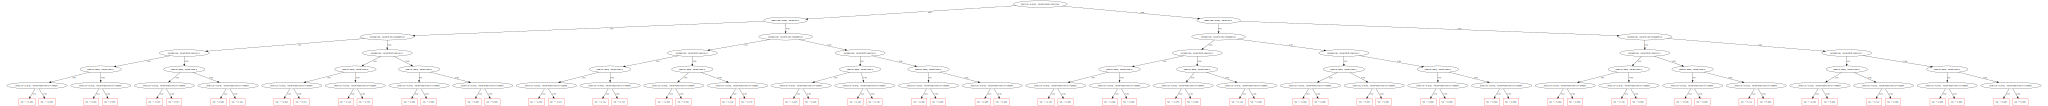

In [10]:
model.plot_tree(tree_idx=0, pool=pool_train)

In [11]:
g = model.plot_tree(tree_idx=0, pool=pool_train)
g.format = 'png'
g.render('/content/drive/MyDrive/CSE578DVGroupProject/CatBoot_Tree', view=True)

'/content/drive/MyDrive/CSE578DVGroupProject/CatBoot_Tree.png'

In [12]:
model.save_model('/content/drive/MyDrive/CSE578DVGroupProject/CatBoost_Model', format="cbm")

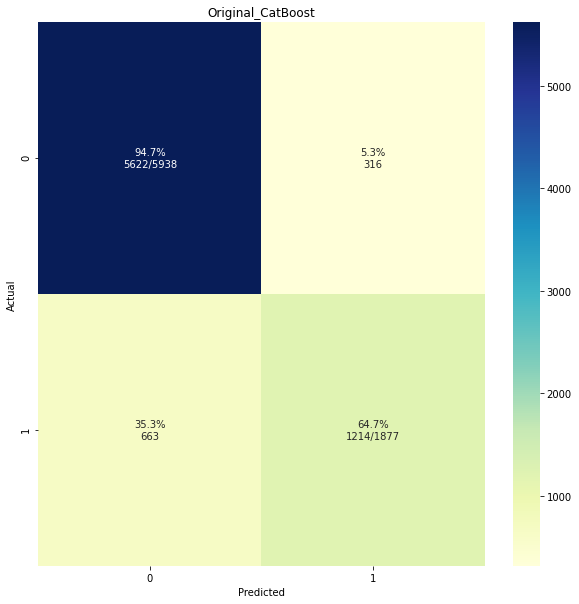

In [13]:
plot_cm(y_cross, predict_cross, 'Original'+'_CatBoost')

In [14]:
columns = model.feature_names_
importance = model.feature_importances_
featureImp = pd.DataFrame()
featureImp['Feature'] = columns
featureImp['Importance'] = importance
featureImp = featureImp.sort_values(by=['Importance'], ascending = False)
featureImp = featureImp.reset_index(drop = True)
featureImp.to_csv('/content/drive/MyDrive/CSE578DVGroupProject/CatBoost_FeatureImp.csv', index = False)
featureImp

,Feature,Importance
0,marital-status,22.317315
1,capital-gain,21.799253
2,age,10.545042
3,occupation,9.165580
4,education,9.160314
5,hours-per-week,7.677542
6,capital-loss,7.302276
7,relationship,3.242064
8,fnlwgt,2.782045
9,workclass,2.291590


# SkyLine Visualization

In [ ]:
#helper function to check whether row1 is better than row2
def betterRow(row1, row2, minimize, maximize):
    better = 0
    for item in maximize:
        if row1[item] < row2[item]:
            return False
        else:
            better += row1[item] > row2[item]
    
    for item in minimize:
        if row1[item] > row2[item]:
            return False
        else:
            better += row1[item] < row2[item]
    
    if better > 0:
        return True
    return False

#helper function to evaluate all rows in data that are not worse than any other row,
# given the constraints to minimize and maximize
def evaluateSkyline(data, minimize, maximize):
    rows = data.to_dict(orient='index')
    answer = set()
    for row1 in rows:
        dominated = False
        for row2 in rows:
            if row1 == row2:
                continue
            elif betterRow(rows[row2], rows[row1], minimize, maximize):
                dominated = True
                break
        if not dominated:
            answer.add(row1)
    return pd.Series(data.index.isin(answer), index=data.index)

In [ ]:
tempData1 = pd.read_csv('/content/drive/MyDrive/CSE578DVGroupProject/perf.csv')
tempData1['Dataset'] = 1
tempData2 = pd.read_csv('/content/drive/MyDrive/CSE578DVGroupProject/perf2.csv')
tempData2['Dataset'] = 2
performanceData = pd.concat([tempData1, tempData2]).reset_index(drop=True)
meanAcc = performanceData['Validation Accuracy'].mean()
meanFit = performanceData['Refit Time'].mean()
print(performanceData.shape)
performanceData = performanceData[performanceData['Validation Accuracy'] >= meanAcc]
performanceData = performanceData[performanceData['Refit Time'] <= meanFit]
performanceData = performanceData.reset_index(drop = True)
print(performanceData.shape)
performanceData

(22, 7)
(11, 7)


,Abbr,Model,Train Accuracy,Validation Accuracy,Refit Time,Misclassified Samples,Dataset
0,AdaBoot,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",86.874600,87.063340,12.546695,1011,1
1,Random Forest,"RandomForestClassifier(bootstrap=True, ccp_alp...",85.611004,85.783749,19.198388,1111,1
2,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",82.690339,82.981446,0.236617,1330,1
3,Neural Network,"MLPClassifier(activation='relu', alpha=0.0001,...",82.693538,82.303263,9.144346,1383,1
4,AdaBoot,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",86.705054,87.165707,26.476736,1003,2
5,Neural Network,"MLPClassifier(activation='relu', alpha=0.0001,...",85.214331,85.527831,14.311756,1131,2
6,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",84.974408,85.182342,1.252151,1158,2
7,Stochastic Gradient Descent,"SGDClassifier(alpha=0.0001, average=False, cla...",84.763276,85.041587,1.507967,1169,2
8,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",84.398592,84.529750,0.932439,1209,2
9,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",83.179782,83.928343,1.926785,1256,2


In [ ]:
skyline_row_idx = evaluateSkyline(performanceData, ['Refit Time'], ['Validation Accuracy'])
performanceData[skyline_row_idx]

,Abbr,Model,Train Accuracy,Validation Accuracy,Refit Time,Misclassified Samples,Dataset
0,AdaBoot,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",86.874600,87.063340,12.546695,1011,1
2,k-Nearest Neighbors,"KNeighborsClassifier(algorithm='auto', leaf_si...",82.690339,82.981446,0.236617,1330,1
4,AdaBoot,"AdaBoostClassifier(algorithm='SAMME.R', base_e...",86.705054,87.165707,26.476736,1003,2
6,Logistic Regression,"LogisticRegression(C=1.0, class_weight=None, d...",84.974408,85.182342,1.252151,1158,2
8,Linear Discriminant Analysis,"LinearDiscriminantAnalysis(n_components=None, ...",84.398592,84.529750,0.932439,1209,2


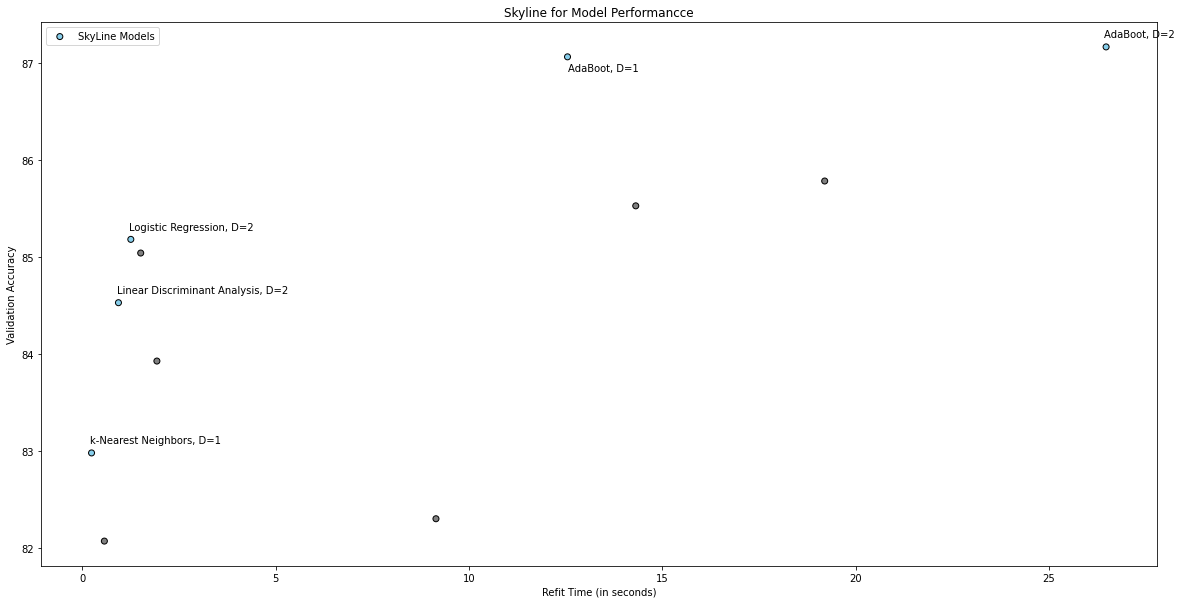

In [ ]:
colors = skyline_row_idx.map({True: 'skyblue', False: 'grey'})
plt.figure(figsize=(20, 10))
plt.scatter(performanceData['Refit Time'], performanceData['Validation Accuracy'], c=colors, edgecolors = 'black')
plt.title('Skyline for Model Performancce')
plt.xlabel('Refit Time (in seconds)')
plt.ylabel('Validation Accuracy')
plt.legend(['SkyLine Models'], loc = 'upper left')

#Annotate
count=0
for idx, row in performanceData.iterrows():
    if (skyline_row_idx[idx]):
        if (count == 0):
            x, y = 0, -0.15
        else:
            x, y = -0.05, 0.10
        txt = str(row['Abbr'])+str(", D=")+str(row['Dataset'])
        plt.annotate(txt, (row['Refit Time']+x, row['Validation Accuracy']+y))
        count+=1
plt.savefig('/content/drive/MyDrive/CSE578DVGroupProject/skyline.png')
plt.show()

# Principal Component Analysis

## Pre Process

In [ ]:
def preprocess(data, scaling = 0):
  #Data pre-processing
  cat_cols = [x for x in data.columns.tolist() if data[x].dtype == 'O']
  bool_dict = {}
  cat_dict = {}
  for col in cat_cols:
    temp = list(data[col].unique())
    if (len(temp) == 2):
      bool_dict[col] = temp
    else:
      cat_dict[col] = temp
  # print("Boolean-category columns:", bool_dict)
  # print("Multi-category columns:", cat_dict)
  #Boolean-Category Columns
  for col in list(bool_dict.keys()):
    for idx, val in enumerate(bool_dict[col]):
      data[col].replace(to_replace = val, value = idx, inplace = True)
  #Multi-Category Columns
  for col in list(cat_dict.keys()):
    for idx, val in enumerate(cat_dict[col]):
      data[col].replace(to_replace = val, value = idx, inplace = True)
  if (scaling == 0):
    print("Label-Encoded Data Shape:", data.shape)
    return data
  
  scaler = MinMaxScaler()
  scaledData = scaler.fit_transform(data)
  scaledData = pd.DataFrame(scaledData, columns=data.columns.tolist())
  print("MinMax Scaled Data Shape:", scaledData.shape)
  return scaledData

## 3D Visualization

In [ ]:
X = data.drop(columns = ['label'])
preX0 = preprocess(X)
X = data.drop(columns = ['label'])
preX1 = preprocess(X, scaling = 1)
y = data['label']
y = np.choose(y, [1, 0]).astype(float)
print(preX0.shape, preX1.shape, y.shape)

Label-Encoded Data Shape: (48842, 13)
MinMax Scaled Data Shape: (48842, 13)
(48842, 13) (48842, 13) (48842,)


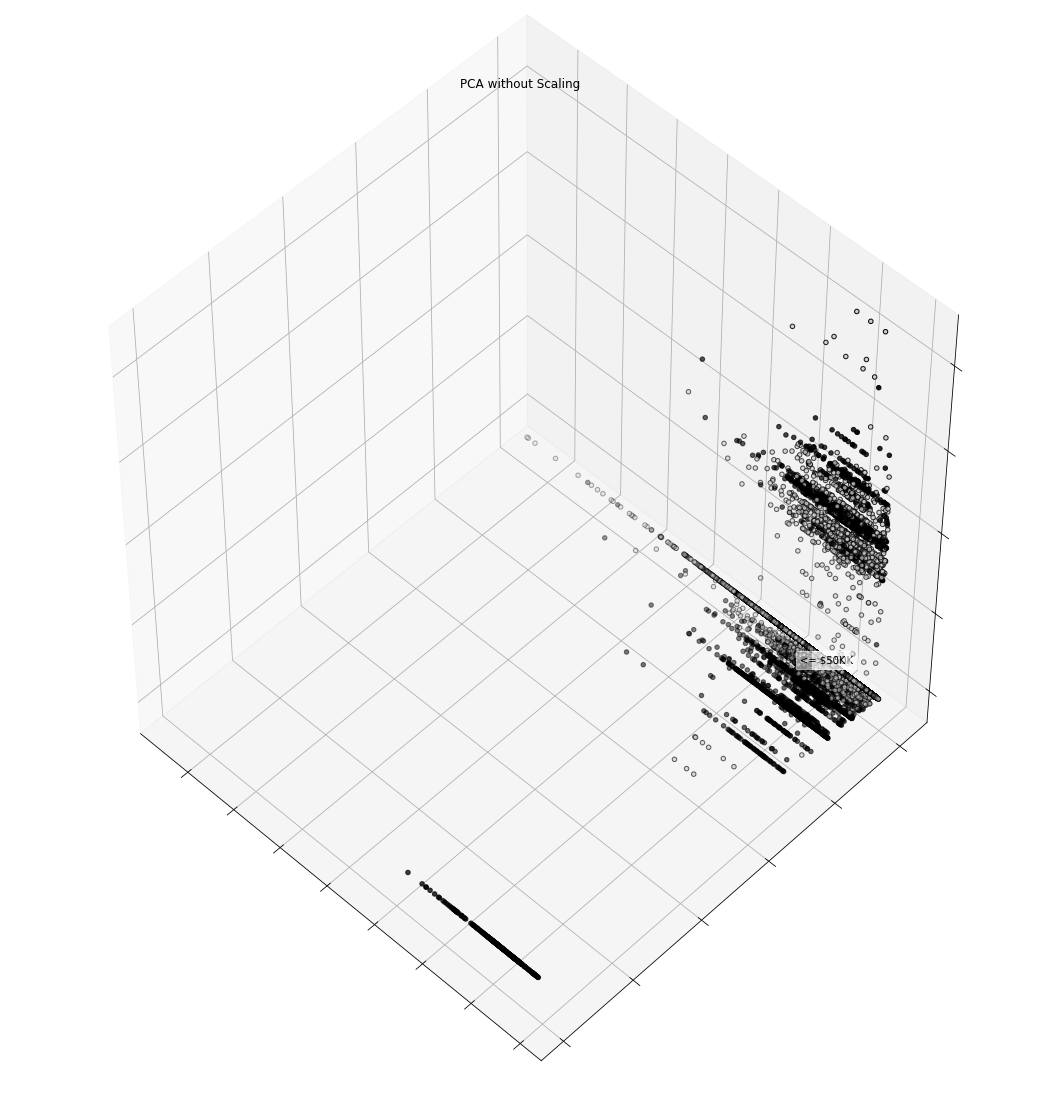

In [ ]:
fig = plt.figure(1, figsize=(15, 15))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(preX0)
preX0 = pca.transform(preX0)

for name, label in [('> $50K', 1), ('<= $50K', 0)]:
    ax.text3D(preX0[y == label, 0].mean(), preX0[y == label, 1].mean() + 1.5, preX0[y == label, 2].mean(), name,
              horizontalalignment='center', bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
ax.scatter(preX0[:, 0], preX0[:, 1], preX0[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.title('PCA without Scaling')
plt.savefig('/content/drive/MyDrive/CSE578DVGroupProject/pca3dwoscale.png')
plt.tight_layout()
plt.show()

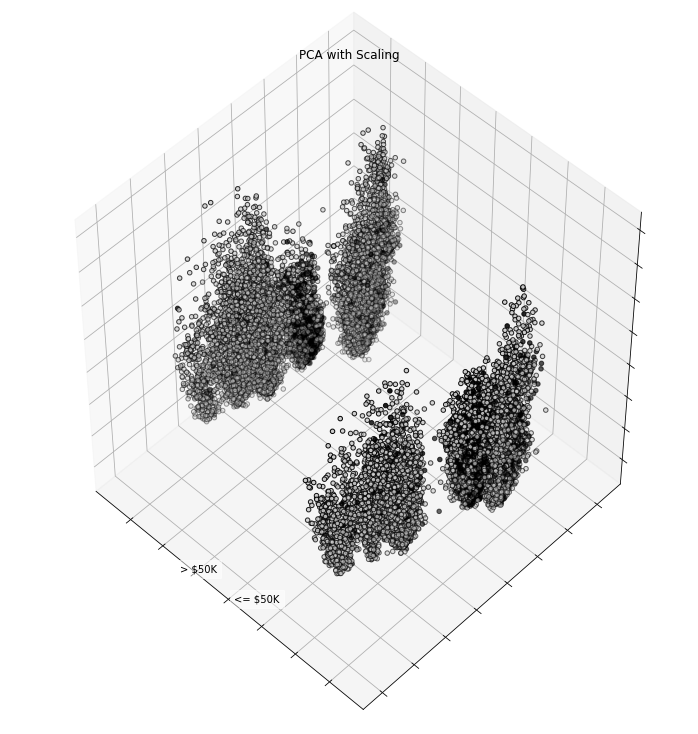

In [ ]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(preX1)
preX1 = pca.transform(preX1)

for name, label in [('> $50K', 1), ('<= $50K', 0)]:
    ax.text3D(preX1[y == label, 0].mean(), preX1[y == label, 1].mean() + 1.5, preX1[y == label, 2].mean(), name,
              horizontalalignment='center', bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
ax.scatter(preX1[:, 0], preX1[:, 1], preX1[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.title('PCA with Scaling')
plt.savefig('/content/drive/MyDrive/CSE578DVGroupProject/pca3dwscale.png')
plt.tight_layout()
plt.show()

## Analysis

In [ ]:
X = data.drop(columns = ['label'])
preX = preprocess(X, scaling = 1)
y = data['label']

MinMax Scaled Data Shape: (48842, 13)


In [ ]:
pca1 = decomposition.PCA()
pca1.fit(preX)
eigenvalues = pca1.explained_variance_
print(eigenvalues)

[0.2354716  0.07897822 0.06210228 0.05255263 0.05070654 0.02582396
 0.02258517 0.01910766 0.01463493 0.01307254 0.00849406 0.00538857
 0.00504414]


In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education', 'marital-status', 'occupation', 
           'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']
featureImp1 = pd.DataFrame()
featureImp1['Feature'] = columns
featureImp1['EigenValue'] = eigenvalues
featureImp1 = featureImp1.sort_values(by=['EigenValue'], ascending = False)
featureImp1 = featureImp1.reset_index(drop = True)
featureImp1.to_csv('/content/drive/MyDrive/CSE578DVGroupProject/PCA_FeatureImp.csv', index = False)
featureImp1

,Feature,EigenValue
0,age,0.235472
1,workclass,0.078978
2,fnlwgt,0.062102
3,education,0.052553
4,marital-status,0.050707
5,occupation,0.025824
6,relationship,0.022585
7,race,0.019108
8,sex,0.014635
9,capital-gain,0.013073
